In [3152]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import time

In [3153]:
pruning_amounts = []
accuracies = []
comp_time = []
model_size = []
with open('pruning_results.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        pruning_amounts.append(float(row[0].replace('%', '')))
        accuracies.append(float(row[1].replace('%', '')))
        comp_time.append(float(row[2]))
        model_size.append(float(row[3]))


In [3154]:
print(f"len accuracies: {len(accuracies)}, len comp_time: {len(comp_time)}, len model_size: {len(model_size)}")

len accuracies: 120, len comp_time: 120, len model_size: 120


In [3155]:
def get_accuracy_reward(accuracy_new,  accuracy_min):
    if accuracy_new > (accuracy_min - 10**-3) and accuracy_new < (accuracy_min + 10**-3):
        return 500.0
    elif accuracy_new > (accuracy_min + 10**-3):
        return (accuracy_new - accuracy_min)*200
    else:
        return (accuracy_min - accuracy_new)*-1000.0

def get_model_size_reward(model_size_new,  model_size_mean):
    delta_model_size = model_size_new - model_size_mean
    if delta_model_size < 0:
        return -100*delta_model_size
    else:
        return 2000*delta_model_size

def get_comp_time_reward(comp_time_new,  comp_time_mean):
    delta_comp_time = comp_time_new - comp_time_mean
    return 100*delta_comp_time if delta_comp_time < 0 else 300 * delta_comp_time

def reward_func(accuracy,  model_size,  comp_time,  accuracy_min,  model_size_min,  comp_time_min,  x=0.0,  y=0.0,  z=0.0):
    accuracy_reward = get_accuracy_reward(accuracy,  accuracy_min)
    model_size_reward = get_model_size_reward(model_size,  model_size_min)
    comp_time_reward = get_comp_time_reward(comp_time,  comp_time_min)
    # print(accuracy_reward,  model_size_reward,  comp_time_reward)
    return (x*accuracy_reward) + (y*model_size_reward) + (z*comp_time_reward)

In [3156]:
old_model_size,  old_comp_time = [model_size[0]], [comp_time[0]]
ACC_MIN = 49
#HYPERPARAMS
random_values = np.random.rand(3)
random_values /= random_values.sum()
ACCURACY_IMP = random_values[0]
MODEL_SIZE_IMP = random_values[1]
COMP_TIME_IMP = random_values[2]

if np.ceil(ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP) != 1:
    print("Sum of hyperparameters = ",  ACCURACY_IMP + MODEL_SIZE_IMP + COMP_TIME_IMP)
    raise ValueError ("Hyperparameters are not correct")
    
print("Original Accuracy",  accuracies[0])

print(f"Hyperparameters: ACCURACY_IMP: {ACCURACY_IMP}, MODEL_SIZE_IMP: {MODEL_SIZE_IMP}, COMP_TIME_IMP: {COMP_TIME_IMP}")

rewards = []

for i in range(0,  len(accuracies)):
    reward = reward_func(accuracies[i],  model_size[i],  comp_time[i],  ACC_MIN,  
                         float(np.mean(old_model_size)),  float(np.mean(old_comp_time)),  ACCURACY_IMP,  MODEL_SIZE_IMP,  COMP_TIME_IMP)
    # print(f"Pruning amount: {pruning_amounts[i]},  Reward: {reward}")
    rewards.append(reward)
    old_model_size.append(model_size[i])
    old_comp_time.append(comp_time[i])

Original Accuracy 53.2
Hyperparameters: ACCURACY_IMP: 0.5625689991736244, MODEL_SIZE_IMP: 0.2651897946361831, COMP_TIME_IMP: 0.17224120619019256


In [3157]:
max(rewards)

np.float64(2488.107785026792)

In [3158]:
index_max = np.argmax(rewards)
print(f"Max reward: {rewards[index_max]},  Pruning amount: {pruning_amounts[index_max]}, accuracy: {accuracies[index_max]},  comp_time: {comp_time[index_max]},  model_size: {model_size[index_max]}")

Max reward: 2488.107785026792,  Pruning amount: 14.5, accuracy: 56.8,  comp_time: 0.0900509357452393,  model_size: 418.657558441162


In [3159]:
def normalize(lst: list) -> list:
    min_val = min(lst)
    max_val = max(lst)
    return ([(x - min_val) / (max_val - min_val) if max_val != min_val else 0 for x in lst])

In [3160]:
normalized_rewards = normalize(rewards)

In [3161]:
sum(comp_time)/len(comp_time)

0.10532490015029906

In [3162]:
sigma = 1e-5
smoothed_rewards = gaussian_filter1d(rewards, sigma=sigma)

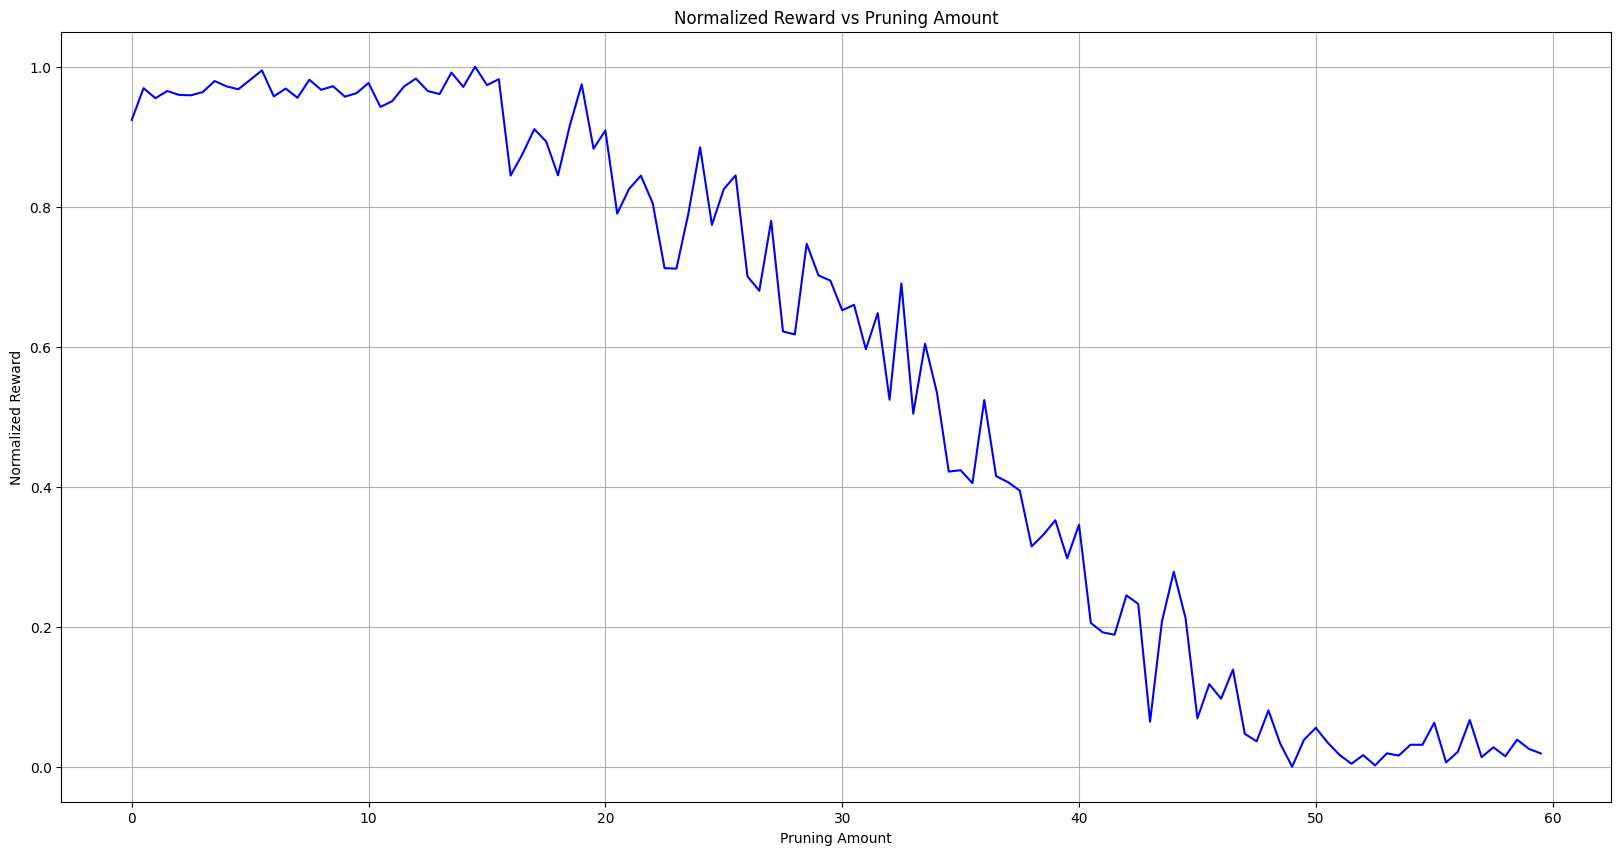

In [3163]:
import matplotlib.pyplot as plt
plt.plot(pruning_amounts, normalize(smoothed_rewards),  label='Reward',  color='blue')
# plt.plot(pruning_amounts, normalize(accuracies),  label='Accuracy',  color='orange')
# plt.plot(pruning_amounts, normalize(model_size),  label='Model Size',  color='green')
# plt.plot(pruning_amounts, normalize(comp_time),  label='Comp Time',  color='red')
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
figsize = plt.gcf()
figsize.set_size_inches(20, 10)
plt.show()

In [3164]:
def first_order_grad(rewards, pruning_amounts):
    sigma = 2  
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))
    smoothed_rewards = rewards

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Gradient ascent parameters
    num_iterations = 100
    learning_rate = 0.1  # Initial step size
    momentum = 0.9       # Momentum factor
    num_restarts = 100    # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)
    pruning_path = []

    start_time = time.time()
    for _ in range(num_restarts):
        # Start from a random pruning amount
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        velocity = 0  # Initialize momentum

        for _ in range(num_iterations):
            # Get the current gradient
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]
            
            # Apply momentum update
            velocity = momentum * velocity + learning_rate * grad
            pruning_amount += velocity  

            # Keep within bounds
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            # Decay learning rate over time for fine-tuning
            learning_rate *= 0.99  

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]
        pruning_path.append(pruning_amount)

        # Track the best solution found
        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    # Print optimal results
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")


    # Plot results
    
    plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
            color="red", s=1, label="Gradient Ascent Steps")
    plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    plt.xlabel("Pruning Amount")
    plt.ylabel("Smoothed Reward")
    plt.title("Finding Global Max with Randomized Gradient Ascent")
    plt.legend()
    plt.grid()
    figsize = plt.gcf()
    figsize.set_size_inches(20, 10)
    plt.show()

In [3165]:
def second_order_grad(rewards, pruning_amounts):
    sigma = 2  
    # smoothed_rewards = normalize(gaussian_filter1d(rewards, sigma=sigma))
    smoothed_rewards = rewards

    # Compute numerical gradient and second derivative (curvature)
    gradients = np.gradient(smoothed_rewards, pruning_amounts)
    curvatures = np.gradient(gradients, pruning_amounts)

    # Gradient ascent parameters
    num_iterations = 10
    initial_learning_rate = 0.1  # Initial step size
    momentum = 0.9               # Momentum factor
    num_restarts = 10            # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        # Start from a random pruning amount
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        velocity = 0  # Initialize momentum
        learning_rate = initial_learning_rate  # Reset learning rate

        for _ in range(num_iterations):
            # Get the current gradient and curvature
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]
            curvature = curvatures[grad_index]

            # Adaptive learning rate using second derivative
            adaptive_lr = learning_rate / (1 + np.abs(curvature))

            # Apply momentum update
            velocity = momentum * velocity + adaptive_lr * grad
            pruning_amount += velocity  

            # Keep within bounds
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            # Decay learning rate over time for fine-tuning
            learning_rate *= 0.99  
            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        # Track the best solution found
        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    # Print optimal results
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
            color="red", s=1, label="Gradient Ascent Steps")
    plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    plt.xlabel("Pruning Amount")
    plt.ylabel("Smoothed Reward")
    plt.title("Finding Global Max with Second-Order Gradient Ascent")
    plt.legend()
    plt.grid()
    figsize = plt.gcf()
    figsize.set_size_inches(20, 10)
    plt.show()

In [3166]:
def adam_grad(rewards, pruning_amounts):
    sigma = 2  
    smoothed_rewards = rewards

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Adam parameters
    num_iterations = 10
    initial_learning_rate = 0.1  # Initial step size
    beta1, beta2 = 0.9, 0.999  # Adam hyperparameters
    epsilon = 1e-8  # To prevent division by zero
    num_restarts = 10  # Random restarts to avoid local maxima
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        m, v = 0, 0  # First and second moments
        learning_rate = initial_learning_rate

        for t in range(1, num_iterations + 1):
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]

            # Adam update
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)  # Bias correction
            v_hat = v / (1 - beta2 ** t)  # Bias correction

            pruning_amount += (learning_rate * m_hat) / (np.sqrt(v_hat) + epsilon)
            pruning_amount = np.clip(pruning_amount, min(pruning_amounts), max(pruning_amounts))

            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
                color="red", s=1, label="Gradient Ascent Steps")
    plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    plt.xlabel("Pruning Amount")
    plt.ylabel("Smoothed Reward")
    plt.title("Finding Global Max with Adam Gradient Ascent")
    plt.legend()
    plt.grid()
    figsize = plt.gcf()
    figsize.set_size_inches(20, 10)
    plt.show()

In [3167]:
def simulated_annealing(rewards, pruning_amounts):
    sigma = 2  
    smoothed_rewards = rewards

    # Compute numerical gradient
    gradients = np.gradient(smoothed_rewards, pruning_amounts)

    # Simulated Annealing parameters
    num_iterations = 10
    initial_temperature = 1.0
    cooling_rate = 0.99
    num_restarts = 10
    best_pruning_amount = None
    best_reward = -np.inf
    pruning_amounts = np.array(pruning_amounts)

    start_time = time.time()
    pruning_path = []

    for _ in range(num_restarts):
        pruning_amount = np.random.uniform(min(pruning_amounts), max(pruning_amounts))
        temperature = initial_temperature

        for _ in range(num_iterations):
            grad_index = np.abs(pruning_amounts - pruning_amount).argmin()
            grad = gradients[grad_index]

            new_pruning = pruning_amount + 0.1 * grad
            new_pruning = np.clip(new_pruning, min(pruning_amounts), max(pruning_amounts))

            # Compute probability of accepting the new state
            delta_reward = smoothed_rewards[np.abs(pruning_amounts - new_pruning).argmin()] - \
                           smoothed_rewards[grad_index]
            if delta_reward > 0 or np.random.rand() < np.exp(delta_reward / temperature):
                pruning_amount = new_pruning

            temperature *= cooling_rate  # Reduce temperature
            pruning_path.append(pruning_amount)

        # Evaluate final reward
        final_index = np.abs(pruning_amounts - pruning_amount).argmin()
        final_reward = smoothed_rewards[final_index]

        if final_reward > best_reward:
            best_reward = final_reward
            best_pruning_amount = pruning_amount

    print(f"Time Taken: {time.time()-start_time} seconds")
    print(f"Optimal pruning amount: {best_pruning_amount:.4f}")
    print(f"Maximum reward: {best_reward:.4f}")

    # Plot results
    plt.plot(pruning_amounts, smoothed_rewards, label="Smoothed Reward", color="blue")
    plt.scatter(pruning_path, np.interp(pruning_path, pruning_amounts, smoothed_rewards), 
                color="red", s=1, label="Gradient Ascent Steps")
    plt.axvline(best_pruning_amount, color="red", linestyle="--", label="Optimal Pruning Amount")
    plt.xlabel("Pruning Amount")
    plt.ylabel("Smoothed Reward")
    plt.title("Finding Global Max with Simulated Annealing")
    plt.legend()
    plt.grid()
    figsize = plt.gcf()
    figsize.set_size_inches(20, 10)
    plt.show()

In [3168]:
def add_pruning_data(pruning_amounts, accuracy, comp_time, model_size, step=0.1, window_size=2, poly_order=1, noise=1.0):
    df = pd.DataFrame({'pruning': pruning_amounts, 'accuracy': accuracy, 'comp_time': comp_time, 'model_size': model_size})
    
    new_pruning_amounts = np.arange(0, np.max(pruning_amounts) + step, step)
    df_interp = df.set_index('pruning').reindex(new_pruning_amounts).interpolate(method='linear')
    
    # Apply Savitzky-Golay filter for smoothing
    def smooth_series(series):
        return savgol_filter(series, window_size, poly_order, mode='nearest') if len(series) > window_size else series
    
    df_interp['accuracy_smooth'] = smooth_series(df_interp['accuracy'].values)
    df_interp['model_size_smooth'] = smooth_series(df_interp['model_size'].values)
    df_interp['comp_time_smooth'] = smooth_series(df_interp['comp_time'].values)
    
    # Add noise if specified
    if noise != 0.0:
        new_acc = smooth_series(df_interp['accuracy_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        new_comp = smooth_series(df_interp['comp_time_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        new_size = smooth_series(df_interp['model_size_smooth'].values) + np.random.logistic(scale=noise, size=len(df_interp))
        return new_pruning_amounts, new_acc, new_comp, new_size
    else:
        return new_pruning_amounts, df_interp['accuracy_smooth'].values, df_interp['comp_time_smooth'].values, df_interp['model_size_smooth'].values


In [3169]:
new_pruning, new_acc, new_comp, new_size = add_pruning_data(
    np.array(pruning_amounts), \
    np.array(accuracies), 
    np.array(comp_time), 
    np.array(model_size), 
    step=0.1,
    window_size=5,
    poly_order=1,
    noise=0.3
)
print(f"pruning {len(new_pruning)}, accuracy {len(new_acc)}, comp_time {len(new_comp)}, model_size {len(new_size)}")

pruning 596, accuracy 596, comp_time 596, model_size 596


In [3170]:
new_rewards = []
old_model_size, old_comp_time = new_size[0], new_comp[0]

for i in range(len(new_pruning)):
    reward = reward_func(
        accuracy=abs(new_acc[i]), model_size=new_size[i], comp_time=new_comp[i], accuracy_min=ACC_MIN,
        model_size_min=old_model_size, comp_time_min=old_comp_time, 
        x=ACCURACY_IMP, y=COMP_TIME_IMP, z=MODEL_SIZE_IMP
    )
    new_rewards.append(float((reward)))

In [3171]:
def save_to_csv(pruning_amounts, accuracies, comp_time, model_size, new_rewards, norm_rewards):
    with open('pruning_results_extra_steps.csv', 'w') as file:
        file.write("Pruning amount, Accuracy, Comp time, Model size, Reward, Norm Reward\n")
        for i in range(len(pruning_amounts)):
            data = f"{pruning_amounts[i]}, {accuracies[i]}, {comp_time[i]}, {model_size[i]}, {rewards[i]}, {norm_rewards[i]}\n"
            file.write(data)

In [3172]:
#print max reward
index_max = np.argmax(new_rewards) 
print(f"Max reward: {new_rewards[index_max]},  Pruning amount: {new_pruning[index_max]}")
print(f"Accuracy at max reward: {new_acc[index_max]},  Comp time: {new_comp[index_max]},  Model size: {new_size[index_max]}")


Max reward: 2538.8109123858867,  Pruning amount: 14.5
Accuracy at max reward: 54.662405645582524,  Comp time: 0.8955770946398923,  Model size: 419.97716885203226


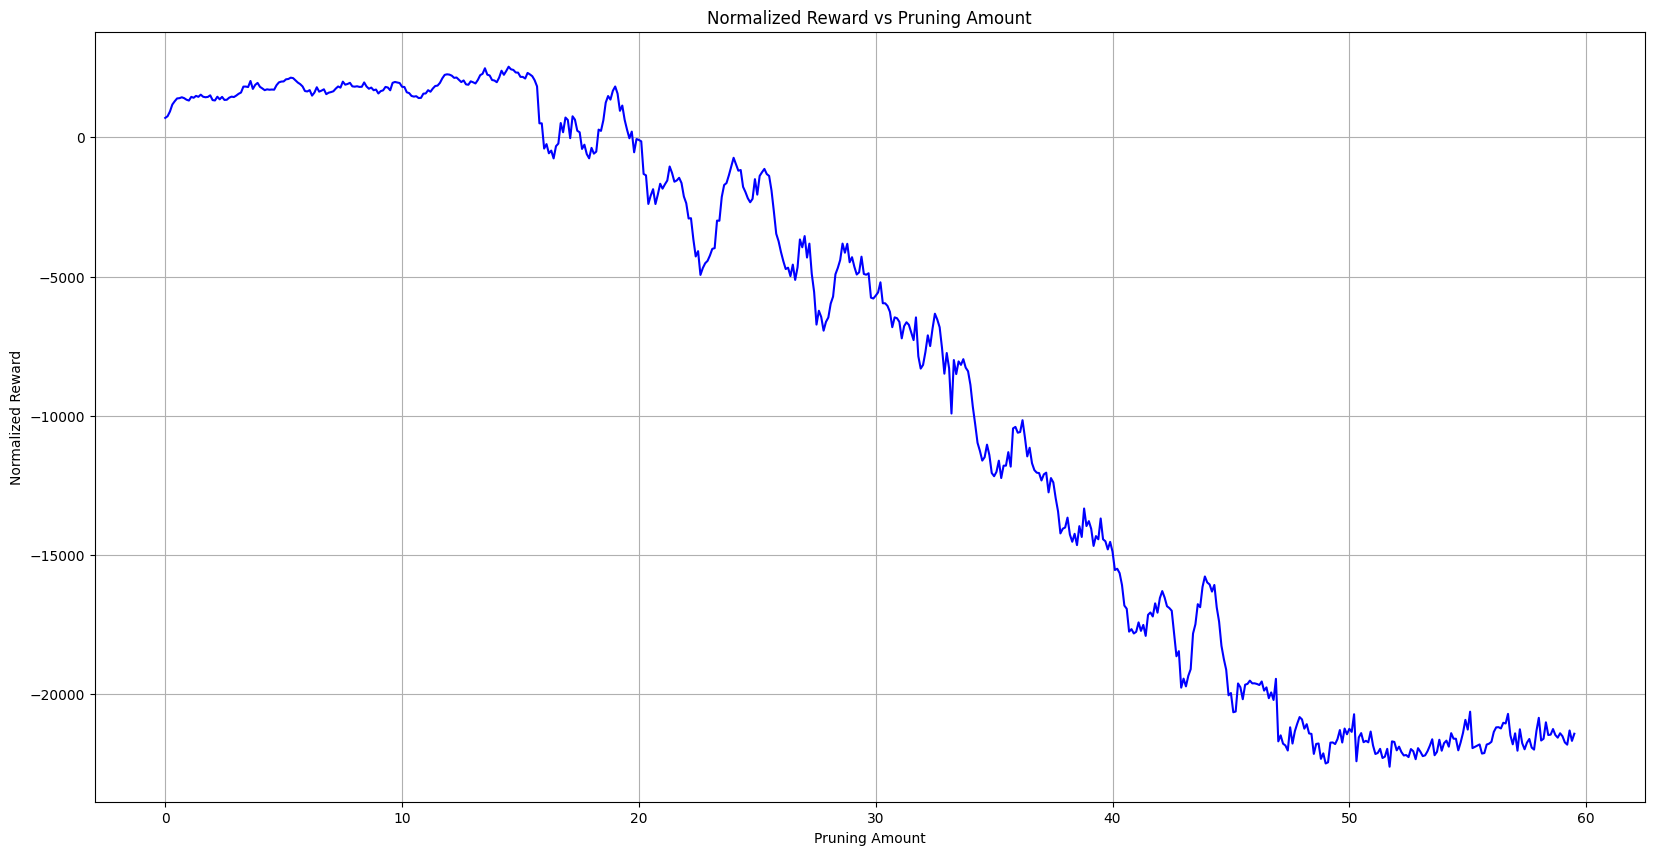

In [3173]:
#plot norm_rewards
import matplotlib.pyplot as plt
plt.plot(new_pruning, new_rewards, label='Reward', color='blue')
plt.xlabel('Pruning Amount')
plt.ylabel('Normalized Reward')
plt.title('Normalized Reward vs Pruning Amount')
plt.grid()
figsize = plt.gcf()
figsize.set_size_inches(20, 10)
plt.show()

Time Taken: 0.005655050277709961 seconds
Optimal pruning amount: 3.0664
Maximum reward: 0.9614


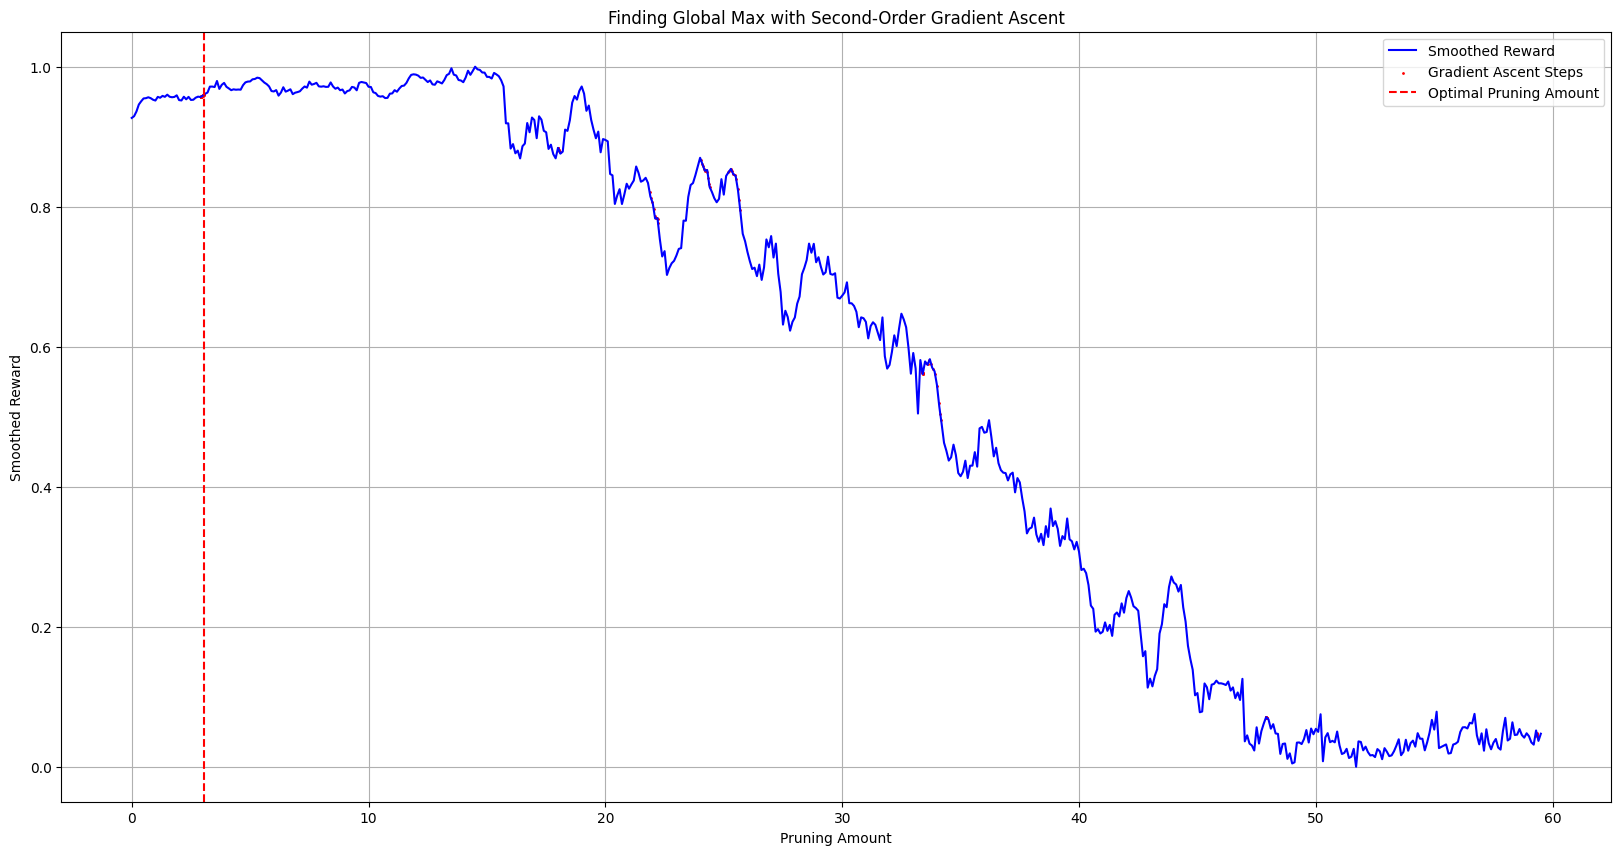

Time Taken: 0.005727052688598633 seconds
Optimal pruning amount: 11.9741
Maximum reward: 0.9887


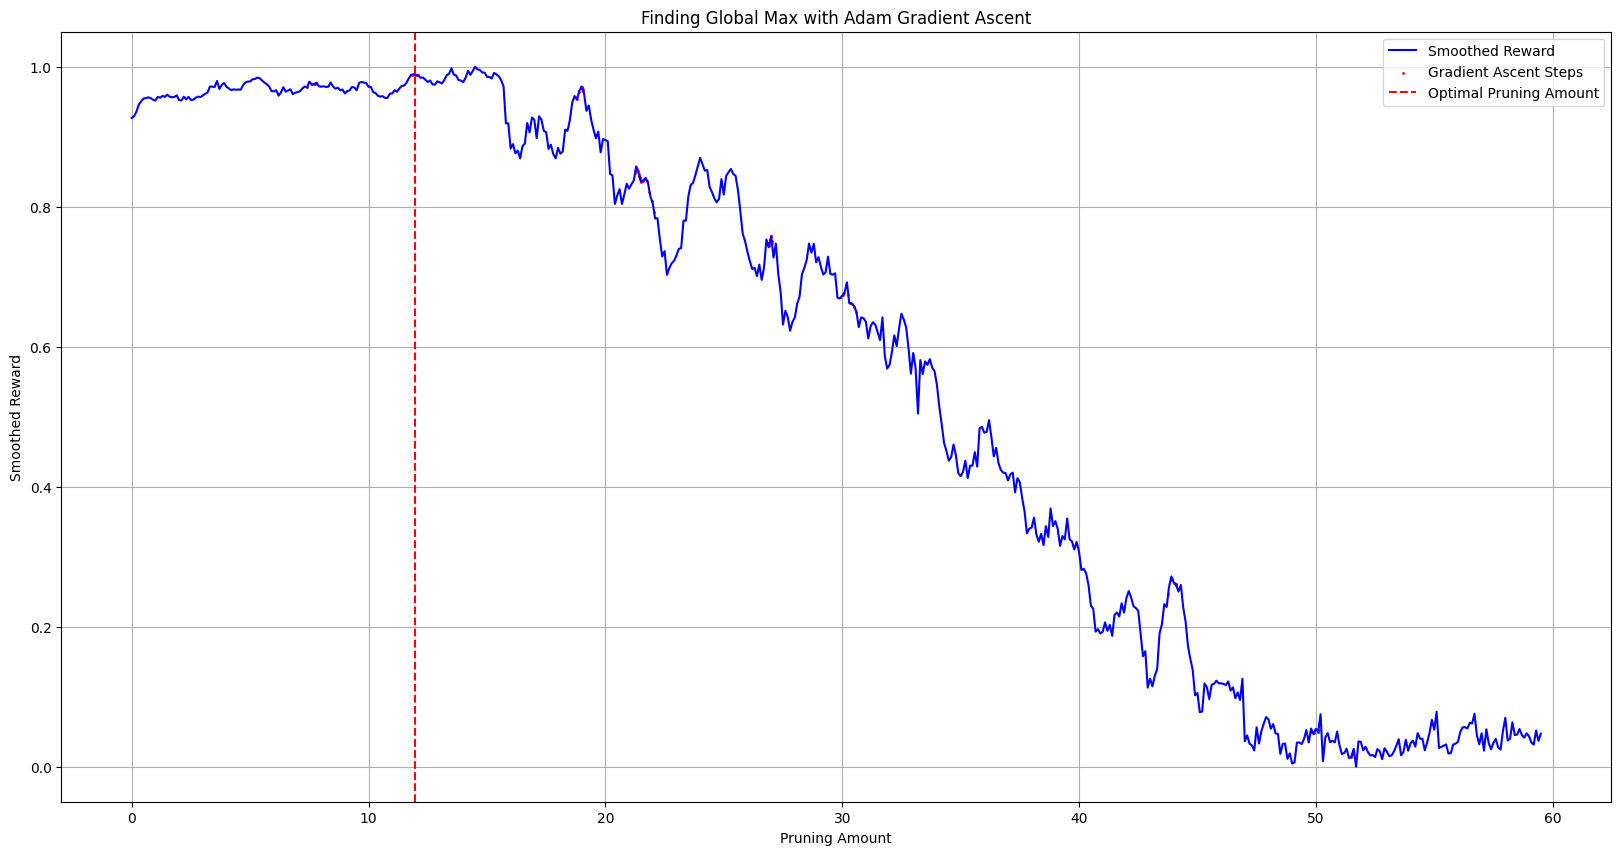

Time Taken: 0.005702972412109375 seconds
Optimal pruning amount: 11.7717
Maximum reward: 0.9883


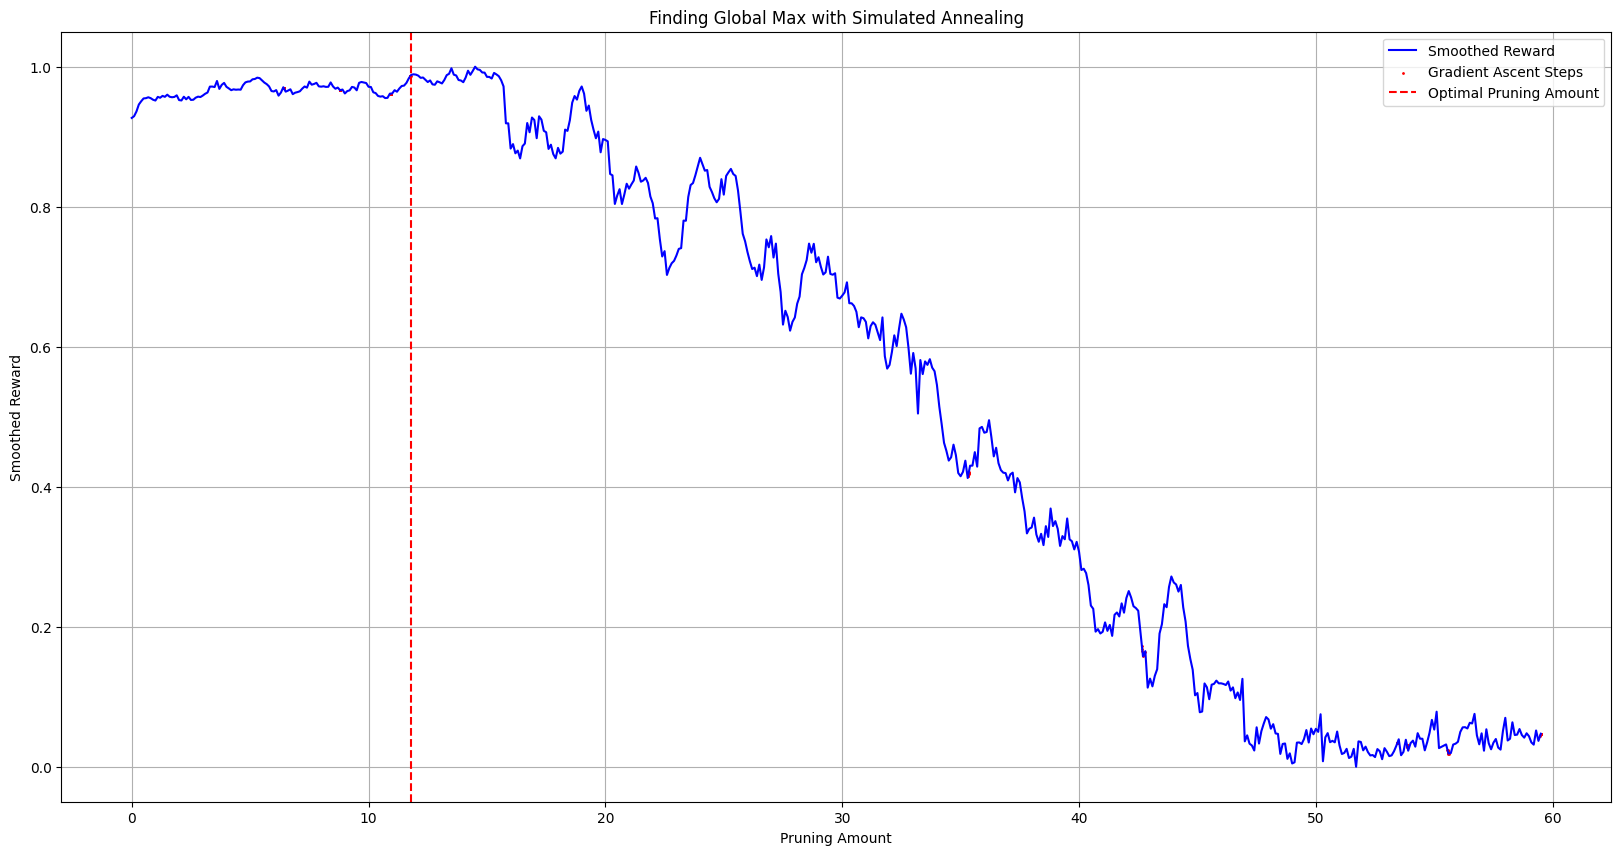

In [3174]:
second_order_grad(normalize(new_rewards), new_pruning)
adam_grad(normalize(new_rewards), new_pruning)
simulated_annealing(normalize(new_rewards), new_pruning)